Connect to the MongoDB database, and access the se collection of the datasets_test database. 
The reader user is only able to list data. 

In [9]:
import pymongo
client = pymongo.MongoClient(
    'mongodb://{}:{}@localhost/?authSource={}&authMechanism=MONGODB-CR'.format(
        'reader', 'MreaderO', 'datasets_test'
    )
)
col = client['datasets_test']['se']

Get all datasets. The first dataset is a test entry, we just remove it. 

In [15]:
datasets = list(col.find({}))
print(datasets[0])
datasets = datasets[1:]
print(len(datasets))

{u'_id': ObjectId('5d075ff978b5f8b13f0dd788'), u'name': u'b', u'tgzs': [2.0, 3.0], u'subdirs': [0.0, 1.0], u'subdir_pattern': u'*', u'path': u'a', u'tgz_pattern': u'*'}
3062


The information obtained from the SE contents is stored in a dictionary. Here is what we get for the first entry: 

In [14]:
datasets[0]

{u'_id': ObjectId('5d07641db232bba0cb3d192e'),
 u'name': u'DY3JetsToLL_M50_LO_ext',
 u'path': u'/store/user/gtouquet/heppyTrees/190503/tt_DY_CMS_scale_j_RelativeBal_13TeV_down/DY3JetsToLL_M50_LO_ext/190505_081410',
 u'subdir_pattern': u'*',
 u'subdirs': [u'0000'],
 u'tgz_pattern': u'*',
 u'tgzs': {u'0000': [u'heppyOutput_1.tgz']}}

A bit or preprocessing. We are going to read the tgzs field to find out how many chunks are in the dataset, and to estimate the fraction of missing chunks.

For now, we assume that the largest chunk number is the number of chunks. This will underestimate computing efficiency, in case the last chunks are missing. 

You can edit the preprocessing function to add what you need in the dataset information. 

In [55]:
import pprint
import re

pattern = re.compile('.*_(\d+)\.tgz$')
def preprocess_chunks(datasets): 
    for ds in datasets: 
        tgzs = ds['tgzs']
        chunks = []
        if len(tgzs)!=1: 
            print('warning, need to see how to deal with 0000,0001, etc')
        for subd, subdchunks in tgzs.iteritems(): 
            # we do not consider the subdirectory, e.g. 0000
            chunks.extend(subdchunks)
        ds['nchunks'] = len(chunks)
        # find max integer
        ids = []
        for chunk in chunks: 
            # print(chunk)
            m = pattern.match(chunk)
            if m: 
                theid = int(m.group(1))
                # print(theid) 
                ids.append(theid)
        ds['chunk_ids'] = sorted(ids)
        ds['max_id'] = max(ids)

In [56]:
preprocess_chunks(datasets)
print(datasets[500])

{u'tgz_pattern': u'*', u'subdir_pattern': u'*', 'nchunks': 40, u'subdirs': [u'0000'], 'chunk_ids': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], u'tgzs': {u'0000': [u'heppyOutput_1.tgz', u'heppyOutput_10.tgz', u'heppyOutput_11.tgz', u'heppyOutput_12.tgz', u'heppyOutput_13.tgz', u'heppyOutput_14.tgz', u'heppyOutput_15.tgz', u'heppyOutput_16.tgz', u'heppyOutput_17.tgz', u'heppyOutput_18.tgz', u'heppyOutput_19.tgz', u'heppyOutput_2.tgz', u'heppyOutput_20.tgz', u'heppyOutput_21.tgz', u'heppyOutput_22.tgz', u'heppyOutput_23.tgz', u'heppyOutput_24.tgz', u'heppyOutput_25.tgz', u'heppyOutput_26.tgz', u'heppyOutput_27.tgz', u'heppyOutput_28.tgz', u'heppyOutput_29.tgz', u'heppyOutput_3.tgz', u'heppyOutput_30.tgz', u'heppyOutput_31.tgz', u'heppyOutput_32.tgz', u'heppyOutput_33.tgz', u'heppyOutput_34.tgz', u'heppyOutput_35.tgz', u'heppyOutput_36.tgz', u'heppyOutput_37.tgz', u'heppyOutput_38.t

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
df = pd.DataFrame(datasets)
df.head()

,_id,chunk_ids,max_id,name,nchunks,path,subdir_pattern,subdirs,tgz_pattern,tgzs
0,5d07641db232bba0cb3d192e,[1],1,DY3JetsToLL_M50_LO_ext,1,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,{u'0000': [u'heppyOutput_1.tgz']}
1,5d07641eb232bba0cb3d192f,"[2, 3, 4]",4,DY4JetsToLL_M50_LO,3,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_2.tgz', u'heppyOutput..."
2,5d07641eb232bba0cb3d1930,"[1, 2, 3, 4]",4,DY4JetsToLL_M50_LO,4,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_1.tgz', u'heppyOutput..."
3,5d076421b232bba0cb3d1933,[47],47,DYJetsToLL_M50,1,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,{u'0000': [u'heppyOutput_47.tgz']}
4,5d076425b232bba0cb3d1938,[1],1,DY2JetsToLL_M50_LO,1,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,{u'0000': [u'heppyOutput_1.tgz']}


## number of chunks

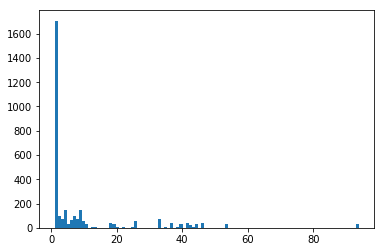

In [67]:
_ = plt.hist(df['nchunks'], bins=100)

## fraction of missing chunks

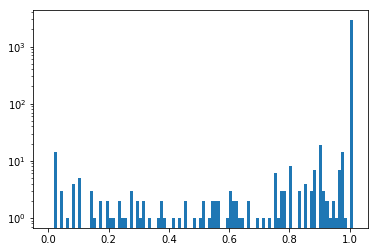

In [76]:
_ = plt.hist(df['nchunks']/df['max_id'], bins=101, range=(0,1.01))
plt.yscale('log')

Filter datasets with a low fraction. First we add the fraction to the dataframe

In [78]:
df['missfrac'] = df['nchunks']/df['max_id']

In [79]:
df[df['missfrac']<0.5]

,_id,chunk_ids,max_id,name,nchunks,path,subdir_pattern,subdirs,tgz_pattern,tgzs,missfrac
3,5d076421b232bba0cb3d1933,[47],47,DYJetsToLL_M50,1,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,{u'0000': [u'heppyOutput_47.tgz']},0.021277
9,5d07642ab232bba0cb3d193e,"[4, 22, 27, 31, 47]",47,DYJetsToLL_M50,5,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_22.tgz', u'heppyOutpu...",0.106383
21,5d0763b1b232bba0cb3d1917,"[3, 4, 5, 13, 16, 22, 23, 26, 36, 47]",47,DYJetsToLL_M50,10,/store/user/gtouquet/heppyTrees/190503/tt_DY_B...,*,[0000],*,"{u'0000': [u'heppyOutput_13.tgz', u'heppyOutpu...",0.212766
31,5d0763bab232bba0cb3d1921,"[2, 21, 40, 47]",47,DYJetsToLL_M50,4,/store/user/gtouquet/heppyTrees/190503/tt_DY_B...,*,[0000],*,"{u'0000': [u'heppyOutput_2.tgz', u'heppyOutput...",0.085106
65,5d076439b232bba0cb3d1950,[47],47,DYJetsToLL_M50,1,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,{u'0000': [u'heppyOutput_47.tgz']},0.021277
66,5d076439b232bba0cb3d1951,"[4, 7, 9, 18, 27, 44, 47]",47,DYJetsToLL_M50,7,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_18.tgz', u'heppyOutpu...",0.148936
77,5d076443b232bba0cb3d195c,[47],47,DYJetsToLL_M50,1,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,{u'0000': [u'heppyOutput_47.tgz']},0.021277
82,5d076447b232bba0cb3d1961,"[2, 5, 8, 9, 10, 14, 19, 31]",31,DY1JetsToLL_M50_LO_ext,8,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_10.tgz', u'heppyOutpu...",0.258065
83,5d076448b232bba0cb3d1962,"[1, 3, 9, 10, 11, 14, 16, 17, 21, 23, 24, 26, ...",32,DY1JetsToLL_M50_LO_ext,14,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_1.tgz', u'heppyOutput...",0.437500
96,5d076452b232bba0cb3d196f,"[6, 7, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, ...",37,DYJetsToLL_M10to50_LO,18,/store/user/gtouquet/heppyTrees/190503/tt_DY_C...,*,[0000],*,"{u'0000': [u'heppyOutput_11.tgz', u'heppyOutpu...",0.486486
